In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [35]:
# Load the dataset
df = pd.read_csv('../Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [36]:
# Drop unwanted columns
df.drop(columns=['customerID'], inplace=True)

In [ ]:
df.info()

In [38]:
# Total charges are object type, convert to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # coerce errors to NaN

In [39]:
df.dropna(inplace=True)  # Drop rows with NaN values

In [ ]:
df.isnull().sum()

In [46]:
for col in df.select_dtypes(include=['object']).columns:
    if col != 'Churn':  # Skip the target variable
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

In [ ]:
df

In [48]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})  # Encode target variable

In [ ]:
df

In [51]:
# Standardization
X = df.drop('Churn', axis=1)
y = df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
## Applying PCA to reduce dimensionality
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # keeping 95% of variance
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", X_scaled.shape)
print("Reduced shape:", X_pca.shape)

Original shape: (7032, 19)
Reduced shape: (7032, 16)


In [55]:
## Anomaly Detection using Isolation Forest
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = iso.fit_predict(X_pca)

In [60]:
print("Total anomalies detected:", (anomaly_labels == -1).sum())

Total anomalies detected: 352


In [61]:
# Combine PCA results with anomaly labels
X_pca_with_anomaly = np.hstack((X_pca, anomaly_labels.reshape(-1, 1)))

*Random Forest algorithm*

In [62]:
# Data into train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca_with_anomaly, y, test_size=0.2, random_state=42)

In [ ]:
pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_resampled).value_counts().to_dict())

In [ ]:
# Applying random forest algorithm
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_resampled, y_resampled)

y_pred = xgb_model.predict(X_test)

In [88]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
cm = confusion_matrix(y_test, y_pred)
print("classification report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", cm)
print("ROC AUC Score:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

classification report:
               precision    recall  f1-score   support

           0       0.88      0.75      0.81      1033
           1       0.51      0.72      0.60       374

    accuracy                           0.74      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.78      0.74      0.76      1407

Confusion Matrix:
 [[778 255]
 [104 270]]
ROC AUC Score: 0.8117134559535335


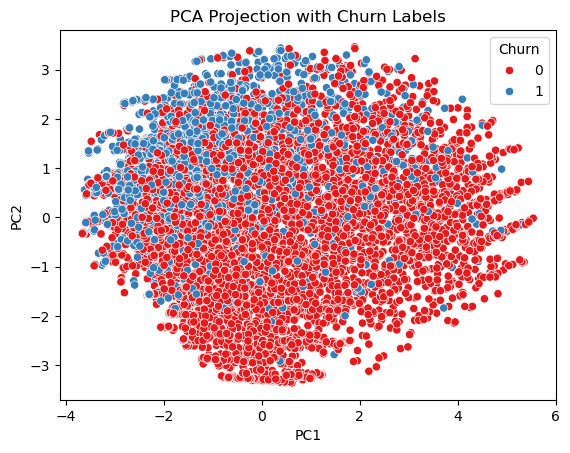

In [90]:
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y, palette='Set1')
plt.title("PCA Projection with Churn Labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
